  # Data Mining and Big Data Analytics: Final Project
  ##  <font color='blue'>CIFAR-10 Image Classification</font>

  ## Salma Taoufiq

Images are an effective capture of the most elusive thing: the present. Through this final project, I wish to scratch the surface of how a computer can 'see' and understand images. Given some binary data, which is essentially an image how can a computer conclude the contents of the given image: that it represents a bird and not a car for instance.

To venture into image classification, I have chosen the CIFAR10 dataset. It is a 10-class dataset with a total of 60k 32x32-pixel color images. Each image belongs to 1 of 10 possible classes: airplane, automobile, bird, cat, deer, dog, frog, horse, ship and truck.


## <font color='red'>Setting the stage</font>

In [0]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

#To get rid of some annoying 'future warnings'
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


from sklearn.model_selection import cross_val_score, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing, svm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

import keras
from keras.models import Sequential
from keras.datasets import cifar10
from keras.layers import Dense,Conv2D,Flatten,Dropout,MaxPooling2D,Activation
from keras.utils.np_utils import to_categorical   
from keras.utils import np_utils
from keras.optimizers import SGD

import cv2


Using TensorFlow backend.


We start by loading the data using the cifar10.load_data() method provided by Keras. 

In [0]:
#Loading the data
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

#Printing its dimensions
print("Info about the training data:")
print(X_train.shape)
print(y_train.shape)
print("As for the test data:")
print(X_test.shape)
print(y_test.shape)

#Taking a subsample of the data
num_training = 700
mask = list(range(num_training))
X_train = X_train[mask]
y_train = y_train[mask]

num_test = 300
mask = list(range(num_test))
X_test = X_test[mask]
y_test = y_test[mask]

170500096/170498071 [==============================] - 55s 0us/step
Info about the training data:
(50000, 32, 32, 3)
(50000, 1)
As for the test data:
(10000, 32, 32, 3)
(10000, 1)


The dataset comes with a predefined split into 50,000 training images and 10,000 test ones.
Each image is structured in a (32,32,3) format corresponding to its width, height, and RGB. Additionnally, each image has a corresponding label: its class index.

Here's a glimpse of what the images look like:

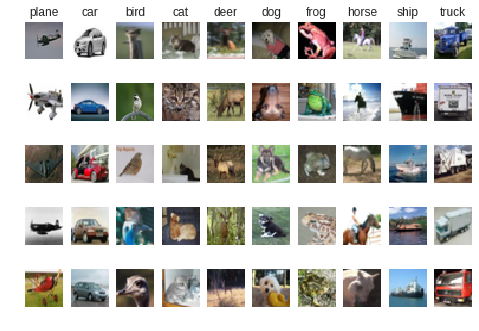

In [0]:
#The classes of images
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)

#Only want to visualize 5 images from each class
num_samples = 5

#Going through the classes and displaying samples of images from each one:
for index, label in enumerate(classes):
    #Getting the non-zero indices corresponding to the class
    val = np.flatnonzero(y_train == index)
    #Picking 5 at random
    val = np.random.choice(val, num_samples, replace=False)
    for i, j in enumerate(val):
        plt_idx = i * num_classes + index + 1
        plt.subplot(num_samples, num_classes, plt_idx)
        plt.axis('off')
        plt.imshow(X_train[j].astype('uint8'))
        if i == 0:
            plt.title(label)
plt.show()

Some squinting is required to distinguish between them. This dataset is very commonly used to train ML and CV algorithms.

In [0]:
X_train_flat = np.reshape(X_train, (X_train.shape[0], -1))
X_test_flat = np.reshape(X_test, (X_test.shape[0], -1))
print(X_train_flat.shape, X_test_flat.shape)

(700, 3072) (300, 3072)


# 1. Some 'classical' classifiers at work:

As we have seen in class time and time again, the dataset entirely decides the fate of the algorithms. We will dive into how a classical KNN, Random Forest, Logistic Regression, and SVM perform when it comes to the task of image classification using the CIFAR10 dataset. 

## <font color='red'>1.1. Distance-based model: KNN</font>

We will start out our exploration of models in image classification with a relatively simple one: the K-Nearest Neighbor classifier, to get an idea of how a distance-based model performs.
First of all, we will apply KNN 'blindly'. Then we will try to improve the results by fine-tuning the hyperparameter K. 

In [0]:
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train_flat, y_train.ravel())
y_pred = knn.predict(X_test_flat)
print('Score obtained: %.2f' %knn.score(X_test_flat, y_test.ravel()))

Score obtained: 0.22


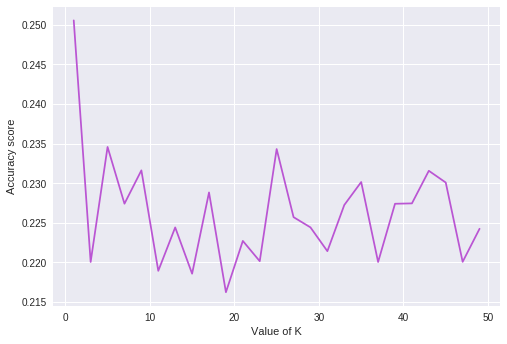

The best number of neighbors is 1 with a score of 25.06%


In [0]:
#Now we will proceed as follows:

#First, we create the list of odd values of K from 1 to 50
possible_K = list(filter(lambda x: x%2 != 0, list(range(1,50))))

#We also create a list to keep track of the cross-valid. scores
cv_scores = []

#We now perform the 5-fold cross-valid. for each value of K
for K in possible_K:
    cv_knn = KNeighborsClassifier(n_neighbors=K)
    #We will each time only record the mean of the accuracy scores for the 10 folds
    scores = cross_val_score(cv_knn, X_train_flat, y_train.ravel(), cv=5, scoring = 'accuracy')
    cv_scores.append(scores.mean())

#Finally, we can plot the scores for each value of K
plt.plot(possible_K, cv_scores, color='mediumorchid')
plt.xlabel('Value of K')
plt.ylabel('Accuracy score')
plt.show()

#Getting the best K:
best_K = possible_K[cv_scores.index(max(cv_scores))]
print("The best number of neighbors is %d" % best_K + ' with a score of %.2f' %(max(cv_scores)*100) + "%")

Even if we try to optimize the KNN classifier to a certain degree by trying to get the optimal K value, it still performs terribly. 

We also note that the optimal K is small (just 1) which restrains the region of our predictions and forces the classifier to be somewhat blind to the overall distribution.

Additionally, we know that a common issue that would cause the KNN to perform badly is the varying ranges of values of the features, such that the one with the greater values dominates the underlying distance metric. In our case, no meaningful scaling can be applied to the images as the pixel values all range between 0 and 255.

We can take a look at this classifier's per-class performance as follows:

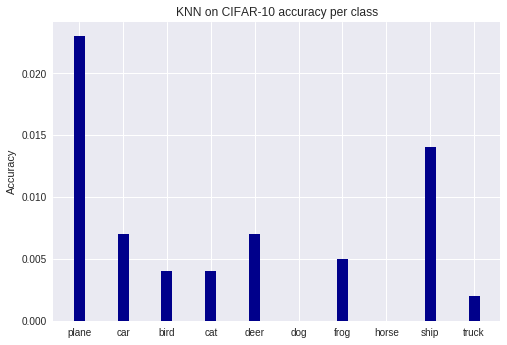

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


              precision    recall  f1-score   support

       plane       0.24      0.64      0.35        36
         car       0.54      0.29      0.38        24
        bird       0.07      0.15      0.10        27
         cat       0.27      0.14      0.18        29
        deer       0.12      0.30      0.18        23
         dog       0.00      0.00      0.00        28
        frog       0.25      0.15      0.19        34
       horse       0.00      0.00      0.00        27
        ship       0.37      0.38      0.37        37
       truck       0.67      0.06      0.11        35

   micro avg       0.22      0.22      0.22       300
   macro avg       0.25      0.21      0.18       300
weighted avg       0.27      0.22      0.19       300



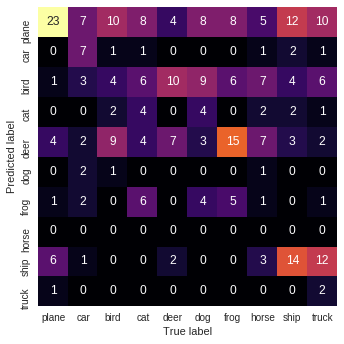

In [0]:
#To store the accuracy of each class 
accuracy_per_class = [0.0]*10

#Collecting the correct predictions for each class
for i in range(y_pred.shape[0]):
    if y_pred[i] == y_test.ravel()[i]:
        accuracy_per_class[y_test.ravel()[i]] += 1.

#Averaging them out
for i in range(10):
    accuracy_per_class[i] /= 1000

#Plotting our results
fig, ax = plt.subplots()
rects = ax.bar(np.arange(10), accuracy_per_class, 0.25, color='darkblue')
ax.set_ylabel('Accuracy')
ax.set_title('KNN on CIFAR-10 accuracy per class')
ax.set_xticks(np.arange(10))
ax.set_xticklabels(classes, rotation='horizontal')
plt.show()

#Classification Report
print(classification_report(y_test.ravel(), y_pred, target_names = classes))

#Confusion Matrix
mat = confusion_matrix(y_test.ravel(), y_pred)
sns.heatmap(mat.T, square=True, annot=True, cmap='inferno', fmt='d', cbar=False, xticklabels=classes, yticklabels=classes)
plt.xlabel('True label')
plt.ylabel('Predicted label');

We notice that the KNN predominantly assigns the label 'plane' to the different instances, and does not even ever predict 'dog' or 'horse'. 
This is further evidence that a regular KNN classifier is unfit for a multi-class problem. We could try to implement multiple KNNs to tackle this classification problem, but KNNs present other problems that could make them unfit for the problem on-hand: KNNs are generally more suited for low-dimensional feature spaces, as well as the fact that it does not really correct its mistakes or 'improve'. It is computationally expensive to train too. It would actually take 'ages' to actually use the real size of the dataset.

Attempting to reduce the dimesions of the dataset does not really lead us anywhere:

In [0]:
#PCA 
pca = PCA(n_components=0.95, whiten=True, random_state=42)
knn = KNeighborsClassifier(n_neighbors=1)

x_train_pca = pca.fit_transform(X_train_flat)
x_test_pca = pca.transform(X_test_flat)

knn.fit(x_train_pca, y_train.ravel())
y_pred_knn = knn.predict(x_test_pca)
knn_score = accuracy_score(y_test.ravel(), y_pred_knn)
print('Post PCA score: %.2f' %knn_score)

Post PCA score: 0.13


## <font color='red'>1.2. Logistic Regression</font>

After our failed attempt with KNN, we will now try using an 'inherently' multiclass model. It uses an OvR (one vs. rest) approach by default.  We feed it PCA-transformed data.

In [0]:
#lr = LogisticRegression(solver = 'lbfgs', multi_class = 'multinomial')
#Sticking to ovr as multinomial to try the softmax regression but it does not lead to better results.
lr = LogisticRegression()
lr.fit(x_train_pca, y_train.ravel())

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [0]:
y_pred_lr = lr.predict(x_test_pca)
logistic_regression_score = accuracy_score(y_test.ravel(), y_pred_lr)
print('Logistic Regression scores: %.2f' %logistic_regression_score)

Logistic Regression scores: 0.25


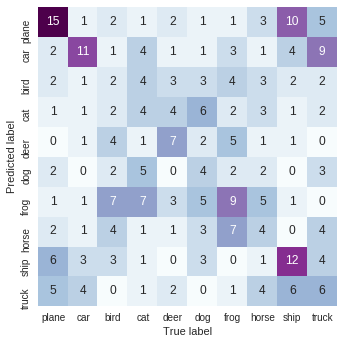

In [0]:
#Confusion Matrix
mat_lr = confusion_matrix(y_test.ravel(), y_pred_lr)
sns.heatmap(mat_lr.T, cmap="BuPu", square=True, annot=True, fmt='d', cbar=False,
            xticklabels=classes,
            yticklabels=classes)
plt.xlabel('True label')
plt.ylabel('Predicted label');

It performs better than the KNN, but still not good enough. 

## <font color='red'>1.3. Support Vector Machine:</font>

From the get-go, we already know that SVMs are binary classifiers, and that they scale poorly with the size of the training set. Luckily, sklearn is adaptable and detects when we are attempting to use a binary classifier on a multi-class problem and adjusts accordingly by going with a one-vs-one or one-vs-all strategy (as we have seen above for LogisticRegression for instance it goes with ovr). Since SVMs can have a really high computational cost for large numbers of training samples, sklearn goes with one-vs-one for this case as it is faster to train many such classifiers on small training sets rather than training few classifiers on large training sets.

In [0]:
clf = svm.SVC(kernel='linear', C=8, gamma='scale')
clf.fit(X_train_flat, y_train.ravel())
print("Accuracy: %.2f"  %clf.score(X_test_flat, y_test.ravel()))

Accuracy: 0.26


This is a very slight improvement from the KNN, and the Logistic Regression.

As we consider each entry of our flattened image matrix as a feature, even for small pictures like the ones in our dataset, this is huge. It would be more effective to preprocess the data and apply some feature extraction to obtain and only work with the really meaningful features. I chose to go with PCA and extract the fundamental components to feed into our support vector machine classifier.

We can do this in a more compact fashion by packaging the preprocessor and the classifier into a single pipeline. For PCA, instead of arbitrarily choosing the number of dimensions (n_components) to reduce down to, I want to pick the number of dimensions that add up to a sufficiently large portion of the variance, for that I chose a float value of 0.95 which represents the ratio of variance I want to preserve: 95% in my case.

In [0]:
#Building my pipleline
pca = PCA(n_components=0.95, whiten=True, random_state=42)
svc = svm.SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)

In [0]:
param_grid = {'svc__C': [1, 5, 10, 50],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01]}
grid = GridSearchCV(model, param_grid, cv = 5, verbose=1, iid=False)
%time grid.fit(X_train_flat, y_train.ravel())
print(grid.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:  1.8min finished


CPU times: user 2min 54s, sys: 39.1 s, total: 3min 33s
Wall time: 1min 50s
{'svc__C': 5, 'svc__gamma': 0.005}


We notice that the resulting optimal values do not fall at the edges of the given parameter lists, so we do not need to adjust these lists. We can now use this best estimator model to make predictions.

In [0]:
model = grid.best_estimator_
yfit = model.predict(X_test_flat)
print("Accuracy: %.2f" %accuracy_score(y_test.ravel(), yfit))

Accuracy: 0.28


Slight improvement from what we've had so far. Let's investigate the resulting predictions and per-class performance.

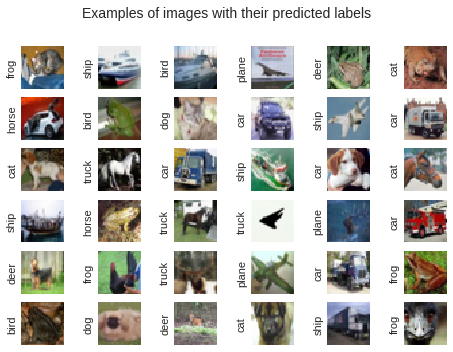

In [0]:
#Showing some images with their predicted labels
fig, ax = plt.subplots(6, 6)

for i, axi in enumerate(ax.flat):
    axi.imshow(X_test[i], cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(classes[yfit[i]])

fig.suptitle('Examples of images with their predicted labels', size=14);

              precision    recall  f1-score   support

       plane       0.36      0.36      0.36        36
         car       0.32      0.58      0.41        24
        bird       0.09      0.07      0.08        27
         cat       0.09      0.07      0.08        29
        deer       0.21      0.39      0.27        23
         dog       0.25      0.11      0.15        28
        frog       0.32      0.24      0.27        34
       horse       0.28      0.19      0.22        27
        ship       0.52      0.41      0.45        37
       truck       0.27      0.37      0.31        35

   micro avg       0.28      0.28      0.28       300
   macro avg       0.27      0.28      0.26       300
weighted avg       0.28      0.28      0.27       300



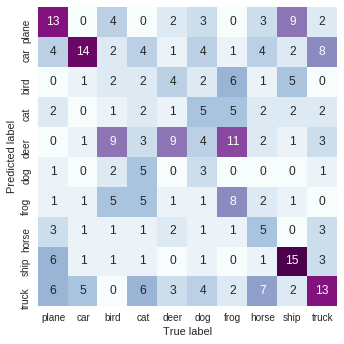

In [0]:
#Classification Report
print(classification_report(y_test.ravel(), yfit, target_names = classes))

#Confusion Matrix
mat = confusion_matrix(y_test.ravel(), yfit)
sns.heatmap(mat.T, cmap="BuPu", square=True, annot=True, fmt='d', cbar=False,
            xticklabels=classes,
            yticklabels=classes)
plt.xlabel('True label')
plt.ylabel('Predicted label');

This model presents very slighlty better results, however training it on the whole 50,000 is not an option as it would be extremely slow and these results are not enough to justify doing such a thing.

##  <font color='red'>1.4. Random Forest:</font>

As an example of an ensemble model, I chose Random Forests. It uses
the results from many different decision trees to calculate
the final result. We expect that the result from an esemble model to be better from any of the individual models.

In [0]:
#Random Forest:

forest = RandomForestClassifier(n_estimators=130, criterion='gini', min_impurity_decrease=0.001,
                                     random_state=159, max_depth = 7)
forest.fit(x_train_pca, y_train.ravel())
y_test_pred = forest.predict(x_test_pca)
print('Score achieved on the test set: %.2f' %accuracy_score(y_test.ravel(), y_test_pred))

y_train_pred = forest.predict(x_train_pca)
print('Score achieved on the training set: %.2f' %accuracy_score(y_train.ravel(), y_train_pred))

Score achieved on the test set: 0.26
Score achieved on the training set: 0.99


Blatant overfitting.

In [0]:
#Setting up the RandomForest and preparing for the grid
rfc=RandomForestClassifier(random_state = 159)
param_grid = { 
    'n_estimators': [100, 200],
    'max_depth' : [5, 7,8, 10, 20],
    'min_impurity_decrease': [0.0, 0.1, 0.01, 0.001, 0.0001]
}

In [0]:
rfc_grid = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
rfc_grid.fit(x_train_pca, y_train.ravel())
rfc_grid.best_params_
print(rfc_grid.best_estimator_)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=None,
            oob_score=False, random_state=159, verbose=0, warm_start=False)


In [0]:
rfc_opt = rfc_grid.best_estimator_
yfit_rfc = rfc_opt.predict(x_test_pca)
print("Accuracy: %.2f" %accuracy_score(y_test.ravel(), yfit_rfc))

Accuracy: 0.25


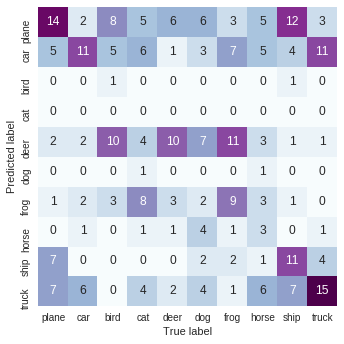

In [0]:
#Confusion Matrix
mat_rfc = confusion_matrix(y_test.ravel(), yfit_rfc)
sns.heatmap(mat_rfc.T, cmap="BuPu", square=True, annot=True, fmt='d', cbar=False,
            xticklabels=classes,
            yticklabels=classes)
plt.xlabel('True label')
plt.ylabel('Predicted label');

With Random Forests, we obtain similar results as for the SVM: unsatisfying. 
We have achieved poor results so far using some classical classification mechanisms. This is quite telling of the fact that some datasets like CIFAR10 are a little harder to grasp.

# 2. Experimenting with Neural Networks:

After investigating the performance of four different models, I want to now gain some insights into a star in the image classification world: convolutional neural networks. As such, I decided to experiment with them through Keras which is an open source neural network Python library which can run on top of other machine learning libraries like TensorFlow, CNTK or Theano. 
First of all, some introductory notes:
- Convolutional neural networks (CNNs) originate from the study of the brain’s visual cortex, and they have been used in image recognition since the 1980s.
- They rely on interesting concepts like convolution, layering, pooling, and backpropagation that, when combined together, give powerful results.

Convolution is this context is about applying a feature detector (a matrix representing a specific feature of the image) to the input and computing the feature map. CNNs develop multiple feature detectors and use them to develop several feature maps and those are our convolutional layers:


![Texte alternatif…](https://sds-platform-private.s3-us-east-2.amazonaws.com/uploads/70_blog_image_5.png)

Source: [1]

Through training, the network determines what features it finds important in order for it to be able to scan images and categorize them more accurately.


**Pooling** is the reduction of the spatial dimensions (width and height) of the input volume for the next convolutional layer. It does not affect the depth dimension of said volume [2]. I will use MaxPooling.


I use the activation function: Rectified Linear Unit: ReLU (z) = max (0, z).

To prevent overfitting, we rely on **Dropout**. It basically randomly drops neurons during the learning stage in order to force the network to make a variety of independent representations of the same data.

Finally, at the level of the tail of our network, we apply a **softmax** function to convert the outputs to probability values for each class. It maps the unnormalized output of the network to a probability distribution over predicted output classes.

By the time we reach this point, this has been a forward pass through our network. Now, on to 
**backpropagation**: simply put, it works as follows: for each training instance the backpropagation algorithm first makes a prediction (forward pass), measures the error, then goes through each layer in reverse to measure the error contribution from each connection (reverse pass), and finally slightly tweaks the connection weights to reduce the error (eg. Gradient Descent step:  iterative optimization algorithm to find the best results (minima of a curve)) [3]. Backpropagation gives us the features and weight values. I chose to use the RMSProp optimizer as it is faster than Gradient Descent.

As for the other hyperparameters (window stride size, number of neurons, etc.), we are the ones to pick them. This is an active area of research actually.

In the following part, we will build a CNN with 4 convolutional layers, kernel size of (3,3).

In [0]:
#Preparing the data

(X_train, y_train), (X_test, y_test) = cifar10.load_data()

y_train = to_categorical(y_train,10)
y_test = to_categorical(y_test,10)
X_train = X_train/255.0
X_test = X_test/255.0

In [0]:
cnn_model = Sequential()

#First convul. layer
cnn_model.add(Conv2D(32, (3, 3), padding='same', input_shape=X_train.shape[1:]))
cnn_model.add(Activation('relu'))
#Second one:
cnn_model.add(Conv2D(32, (3, 3)))
cnn_model.add(Activation('relu'))
#We apply pooling to downsample using MaxPooling
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
#Regularizing using Dropout to avoid overfitting
cnn_model.add(Dropout(0.25))
#Third convol. layer
cnn_model.add(Conv2D(64, (3, 3), padding='same'))
cnn_model.add(Activation('relu'))
#Fourth and last one
cnn_model.add(Conv2D(64, (3, 3)))
cnn_model.add(Activation('relu'))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Dropout(0.25))
#Flattening to get ready to pass it on to the network
cnn_model.add(Flatten())
#Dense layer to connect all nodes with the ones in the preceding layer: the actual classification occurs
cnn_model.add(Dense(512))
cnn_model.add(Activation('relu'))
cnn_model.add(Dropout(0.5))
#One neuron for each target class:
cnn_model.add(Dense(10))

#Finally, we have reached activation for which we use the softmax approach
cnn_model.add(Activation('softmax'))
#Setting up the optimizer
opt = keras.optimizers.rmsprop(lr=0.0001, decay=1e-6)

#Training the model using the chosen optimizer RMSProp
cnn_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

#1 batch_size = number of training examples in one batch
batch_size = 32
#1 epoch = the entire dataset is passed forward and backward through the CNN once
epochs = 80

cnn = cnn_model.fit(X_train, y_train, batch_size, epochs, validation_data=(X_test,y_test),shuffle=True)

Train on 50000 samples, validate on 10000 samples
Epoch 1/80
50000/50000 [==============================] - 20s 409us/step - loss: 1.8262 - acc: 0.3323 - val_loss: 1.6228 - val_acc: 0.4124
Epoch 2/80
50000/50000 [==============================] - 20s 391us/step - loss: 1.5018 - acc: 0.4553 - val_loss: 1.4600 - val_acc: 0.4845
Epoch 3/80
50000/50000 [==============================] - 20s 391us/step - loss: 1.3587 - acc: 0.5127 - val_loss: 1.2429 - val_acc: 0.5581
Epoch 4/80
50000/50000 [==============================] - 20s 391us/step - loss: 1.2586 - acc: 0.5529 - val_loss: 1.1730 - val_acc: 0.5825
Epoch 5/80
50000/50000 [==============================] - 19s 390us/step - loss: 1.1794 - acc: 0.5834 - val_loss: 1.1037 - val_acc: 0.6082
Epoch 6/80
50000/50000 [==============================] - 20s 391us/step - loss: 1.1147 - acc: 0.6082 - val_loss: 1.1347 - val_acc: 0.6082
Epoch 7/80
50000/50000 [==============================] - 20s 392us/step - loss: 1.0596 - acc: 0.6287 - val_loss: 1.

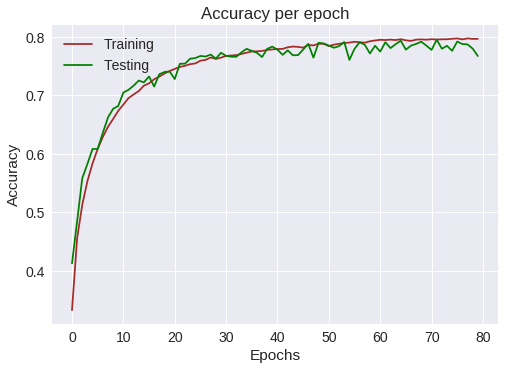

In [0]:
fig = plt.plot(cnn.history["acc"],label = "Training", color='brown')
plt.plot(cnn.history["val_acc"],label = "Testing", color='green')
plt.legend(loc='upper left')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Accuracy per epoch")
plt.show()

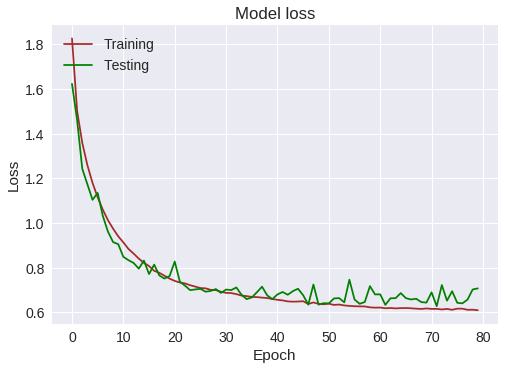

In [0]:
plt.plot(cnn.history['loss'], color ='brown')
plt.plot(cnn.history['val_loss'], color='green')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Testing'], loc='upper left')
plt.show()

[[762  18  64  10  51   2  24   4  41  24]
 [  9 898   3   4   4   2  11   0  11  58]
 [ 36   2 646  10 120  30 143   3   5   5]
 [  8   6  63 474 112 110 187  14  10  16]
 [  8   2  32  10 853   3  67  19   5   1]
 [  3   3  60  94  66 677  73  18   2   4]
 [  3   0  19   9  17   3 945   1   3   0]
 [  7   4  41  26 140  32  25 713   0  12]
 [ 50  31  16   5  18   1  18   1 838  22]
 [ 14  56   5   5   7   4  20   3  20 866]]


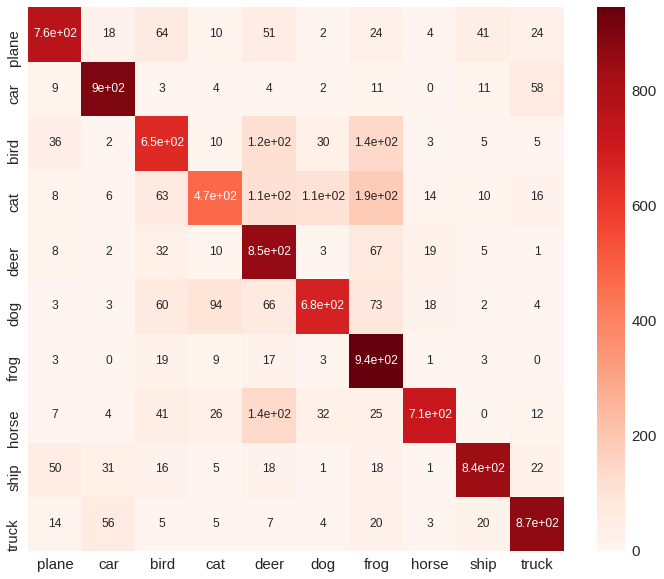

In [0]:
#Confusion Matrix
y_prediction = cnn_model.predict(X_test)
y_predict = np.argmax(y_prediction, axis=1)

confmat = confusion_matrix(np.argmax(y_test, axis=1),y_predict)


cm = pd.DataFrame(confmat, classes, classes)
plt.figure(figsize = (12,10))
sns.set(font_scale=1.5)
print(confmat)
sns.heatmap(cm, annot=True, cmap='Reds', annot_kws={"size": 12})
plt.show()


# Conclusions:
All in all, we have gained more insight into some of the classification algorithms studied in class and scratched the surface of convolutional neural networks. The latter seems to be the most suitable classifier for an image classification task such as this one with the CIFAR-10 dataset. It has outperformed all the other models we attempted. This gives us a foretaste of their powerfulness in dealing with complex patterns. It is worth mentioning however that CNNs are not suitable for all types of datasets such as the tabular ones (customer data, etc.).

## Sources:
1. SuperDataScience. "Convolutional Neural Networks (CNN): Step 1- Convolution Operation". https://www.superdatascience.com/blogs/convolutional-neural-networks-cnn-step-1-convolution-operation
2. Raval, Siraj. "Convolutional Neural Networks - The Math of Intelligence". https://youtu.be/FTr3n7uBIuE
3. Géron, Aurélien. *Hands-On Machine Learning with Scikit-Learn and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems*. O'Reilly Media. March, 2017.
